Learnt from https://gist.github.com/scturtle/9052852

I have provided documentation to show my understanding

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
class Line:
    # stores vertices & mid points
    def __init__(self, l):
        self.point = l
        x1, y1, x2, y2 = l
        self.c_x = (x1 + x2) / 2
        self.c_y = (y1 + y2) / 2

### Function to determine intersection point of 2 lines

In [3]:
def intersection(l1, l2):
    
    x1, y1, x2, y2 = l1.point
    x3, y3, x4, y4 = l2.point
    
    a1, b1 = y2 - y1, x1 - x2
    c1 = a1 * x1 + b1 * y1
    
    a2, b2 = y4 - y3, x3 - x4
    c2 = a2 * x3 + b2 * y3
    
    det = a1 * b2 - a2 * b1
    
    if not det:
        "lines are parallel"
        
    return (1. * (b2 * c1 - b1 * c2) / det, 1. * (a1 * c2 - a2 * c1) / det)

### Read and display image

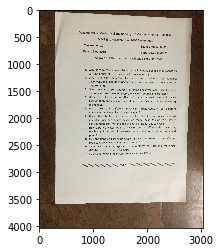

In [4]:
img = cv2.imread('cam.jpg', 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

### Resize all images to a pre-defined scale

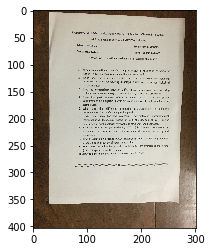

In [5]:
h, w, c = img.shape

# determines scale
min_w = 300
scale = min(10.0, w*1./min_w)

h_proc = int(h * 1. / scale)
w_proc = int(w * 1. / scale)
im_dis = cv2.resize(img, (w_proc, h_proc))

plt.imshow(cv2.cvtColor(im_dis, cv2.COLOR_BGR2RGB))
plt.show()

### Grayscale and blur for further image processing

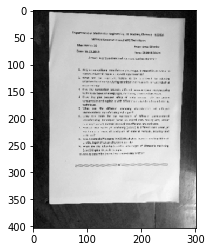

In [6]:
gray = cv2.cvtColor(im_dis, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray,(3,3),0)

plt.imshow(gray, cmap='gray')
plt.show()

### OTSU thresholding for bimodal image

In [7]:
high_thresh, _ = cv2.threshold(gray, 0, 255,
                              cv2.THRESH_BINARY |
                              cv2.THRESH_OTSU)

low_thresh = 0.5*high_thresh

### Canny edge detection 

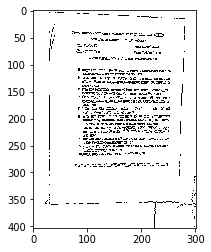

In [8]:
canny = cv2.Canny(gray, low_thresh, high_thresh)

plt.imshow(canny, cmap='Greys')
plt.show()

### Using Hough lines for straight lines detection

In [9]:
lines = cv2.HoughLinesP(canny, 1, np.pi/180, w_proc//3, None, w_proc//3, 20)

### Classifying lines as horizontal and vertical

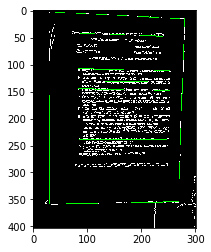

In [10]:
t = cv2.cvtColor(canny, cv2.COLOR_GRAY2BGR)

hori, vert = [], []
for line in lines:
    for l in line:
        x1, y1, x2, y2 = l
        if abs(x1 - x2) > abs(y1 - y2):
            hori.append(Line(l))
        else:
            vert.append(Line(l))
        cv2.line(t, (x1, y1), (x2, y2), (0, 255, 0), 1)

plt.imshow(t)
plt.show()

### Take image boundaries to be document boundaries if we dont have enough lines

In [11]:
if len(hori) < 2:
    if not hori or hori[0].c_y > h_proc / 2:
        hori.append(Line((0, 0, w_proc - 1, 0)))
    if not hori or hori[0].c_y <= h_proc / 2:
        hori.append(Line((0, h_proc - 1, w_proc - 1, h_proc - 1)))

if len(vert) < 2:
    if not vert or vert[0].c_x > w_proc / 2:
        vert.append(Line((0, 0, 0, h_proc - 1)))
    if not vert or vert[0].c_x <= w_proc / 2:
        vert.append(Line((w_proc - 1, 0, w_proc - 1, h_proc - 1)))

### Sort to be able to select left, right, top & bottom lines

In [12]:
hori.sort(key=lambda l: l.c_y)
vert.sort(key=lambda l: l.c_x)

### Visualise the extreme lines - edges

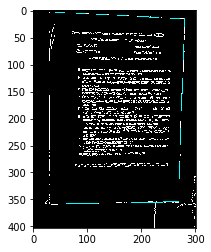

In [13]:
f = cv2.cvtColor(canny, cv2.COLOR_GRAY2BGR)

for l in [hori[0], vert[0], hori[-1], vert[-1]]:
            x1, y1, x2, y2 = l.point
            cv2.line(f, (x1, y1), (x2, y2), (0, 255, 255), 1)

plt.imshow(f)
plt.show()

### Find intersecting points of these edges

In [14]:
img_pts = [intersection(hori[0], vert[0]),
           intersection(hori[0], vert[-1]),
           intersection(hori[-1], vert[0]),
           intersection(hori[-1], vert[-1])]

### Visualise intersections

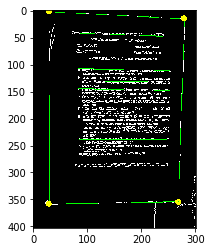

In [15]:
for i, p in enumerate(img_pts):
        x, y = p
        img_pts[i] = (x * scale, y * scale)
        cv2.circle(t, (int(x), int(y)), 3, (255, 255, 0), 3)
plt.imshow(t)
plt.show()    

### Applying perspective transform

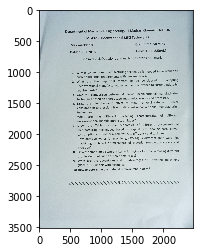

In [16]:
# A4 at 300 dpi
w_a4, h_a4 = 2480, 3508 

op_pts = np.array(((0, 0),
                    (w_a4 - 1, 0),
                    (0, h_a4 - 1),
                    (w_a4 - 1, h_a4 - 1)),np.float32)

img_pts = np.array(img_pts, np.float32)

transmtx = cv2.getPerspectiveTransform(img_pts, op_pts)

output = cv2.warpPerspective(img, transmtx, (w_a4, h_a4))

plt.imshow(output)
plt.show()  

### Truncated threshold for brighter result

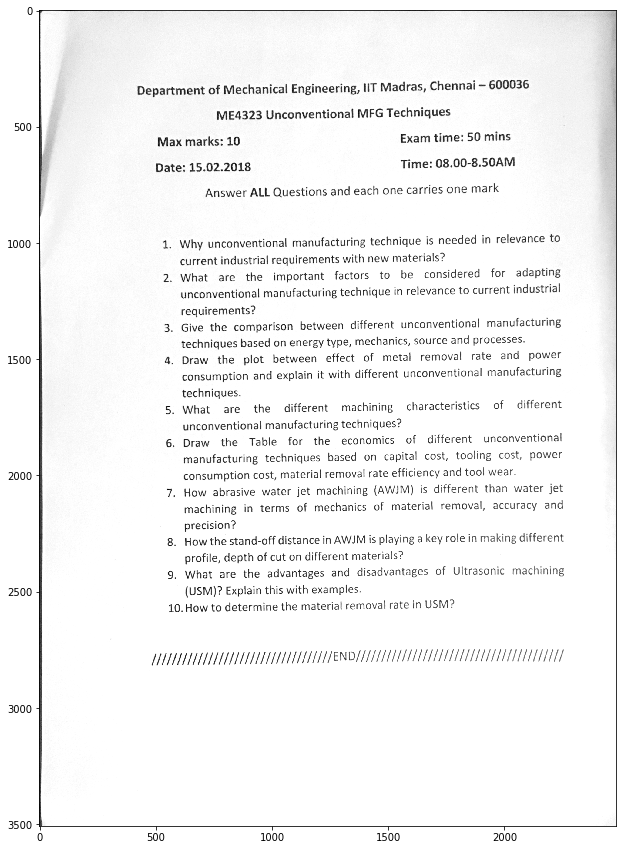

In [17]:
new = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)
_, new = cv2.threshold(new, 200, 255, cv2.THRESH_TRUNC)


plt.rcParams["figure.figsize"] = (50, 15)
plt.imshow(new, cmap='gray')
plt.show()  